#**CHAPTER 9. AI IN HUMANITIES**
---

##0.REFERENCE

https://chatgpt.com/share/69863d09-1b40-8012-a30e-92492929bbdc

##1.CONTEXT

**INTRODUCTION**

This notebook is a controlled synthetic experiment designed to make a specific failure mode in knowledge work visible, measurable, and auditable: evidence drift under iterative revision. In many professional contexts, documents are revised repeatedly to improve clarity, structure, tone, and narrative coherence. The revision process is widely assumed to be beneficial—an editing step that makes content more legible while preserving its underlying meaning. The core claim explored here is narrower and more operational: repeated revision can gradually detach claims from the evidence they purport to summarize, and the detachment can be subtle enough that naive evaluation practices fail to detect it.

The context for this experiment is interpretive AI used in disciplines where evidentiary discipline is central: governance, finance, economics, risk review, and high-stakes communication. In these environments, “good writing” is not only writing that is fluent or persuasive. It is writing that remains tethered to an auditable evidence base, with visible provenance and stable factual anchors. The danger is not simply that a claim becomes incorrect; the danger is that a claim becomes less verifiable while remaining plausible. A plausible claim with weakened provenance can travel further and faster than a clearly speculative claim because it passes informal plausibility filters. The risk is therefore epistemic: the organization’s narrative can begin to decouple from its evidence without any single revision being obviously wrong.

The notebook implements this phenomenon as a controlled experiment rather than an anecdotal argument. It starts by constructing a synthetic evidence corpus: a small set of source documents containing explicit numeric anchors and key terms. This corpus is intentionally synthetic to avoid any real-world advice, ranking, or implication of deployment readiness. The synthetic design is a feature, not a limitation. It allows the experiment to isolate the mechanism, control the parameters that drive it, and measure outcomes precisely without introducing confounds from real data and real institutional context.

From this synthetic corpus, the notebook defines a baseline set of claims. Each claim is explicitly linked to exactly one source through a citation marker. This baseline condition represents an idealized state of evidentiary discipline: the narrative layer (claims) has a clean chain of custody to the evidence layer (sources). The experiment then subjects these claims to an iterative revision process. The revision engine is stochastic and parameterized, modeling “revision pressure” as a set of transformation probabilities rather than as a vague concept. In each revision step, claims can be paraphrased, terms can be replaced by near-synonyms, numeric values can be perturbed within a bounded range, explicit citation markers can be dropped, and causal language can be injected into what were previously descriptive statements.

These transformation channels correspond to common dynamics in real knowledge work. Paraphrasing can slowly shift meaning through accumulated micro-changes. Term substitution can change the implied construct, even if the surface meaning seems similar. Numeric perturbations model rounding, transcription errors, or unintended changes introduced when “cleaning up” prose. Citation dropping models a loss of provenance visibility, often justified as improving readability or reducing clutter. Causal injection models interpretive contamination: a narrative can acquire causal implications not supported by the evidence, especially when revisions aim to make a document feel more explanatory or decisive.

The key governance point is that these changes can interact. A document can become more fluent while simultaneously becoming less tethered to evidence. More importantly, single-metric evaluation can mislead reviewers. If evaluation focuses on a single measure—such as semantic similarity between the revised claim and the original evidence, or an overall “quality” score—a document can appear stable on average while integrity fails in specific dimensions. Two dimensions are especially important: tails and provenance. Tails matter because institutional harm is often driven by a small number of severe errors rather than by average performance. Provenance matters because the ability to verify claims is itself a control mechanism; when provenance is lost, verification becomes costly and therefore less likely to occur.

To make these issues concrete, the notebook implements a multi-metric evaluation suite. It computes a transparent semantic similarity score using TF-IDF and cosine similarity, providing a coarse measure of topical alignment. It computes numeric anchor consistency, checking whether the numbers in a claim remain within tolerance of the numbers present in the cited source. It measures provenance visibility through citation marker presence. It flags causal language through a simple lexical rule to capture interpretive contamination. It also emphasizes tail drift by tracking the worst-performing subset of claims rather than collapsing everything into an average. This suite is not intended as a production verifier; it is intended as a didactic demonstration that integrity is multidimensional and that governance requires visibility into more than one score.

The experiment is then extended through a stress suite. Instead of running one set of revision parameters, the notebook defines multiple regimes—high discipline versus low discipline, low revision pressure versus high revision pressure. These regimes serve as synthetic analogues of organizational environments. The point is not to claim that any organization maps exactly to a parameter setting. The point is to show that integrity outcomes are systematically sensitive to the revision environment, and that different evaluation metrics respond differently. In particular, mean semantic similarity can remain relatively high while tail drift grows and citation rates collapse. This gap illustrates the single-metric trap: evaluators can be shown a “good average” and still face severe integrity failures in the subset of outputs that matter most.

A core design choice in the notebook is governance-first instrumentation. The notebook constructs a run manifest, fingerprints the environment, saves figures and payloads as durable artifacts, and records hashes for integrity. This is more than engineering hygiene. It reflects the central theme of evidentiary discipline: interpretive systems require an auditable chain of custody. The notebook treats its own outputs as evidence: figures are saved and registered, payloads are saved and registered, and the interpretive report produced by the LLM is saved and registered. This creates a complete loop: the computational experiment produces a structured evidence bundle; the narrative layer consumes only that bundle; and the result is an audit artifact that can be verified against its inputs.

The final step is the generation of an intelligent audit report by an LLM, restricted to Cell 10. This is not framed as a demonstration of “AI writing.” It is framed as a governance pattern: if a model is used to produce interpretive narrative, its inputs must be constrained to a structured payload, its output must be forced into a controlled audit structure, and it must be subject to post-generation compliance scans. The notebook enforces that structure by requiring that the report explicitly state synthetic status and lack of validation, by prohibiting advice and prescriptive language, and by scanning outputs for violations. The report is treated as an interpretive artifact, not a decision tool, and the notebook’s design reinforces that boundary.

In sum, the notebook demonstrates a mechanism rather than a general claim about knowledge work. Under iterative revision pressure, content can drift away from evidence, and the drift can appear first in tails, provenance loss, numeric anchor corruption, or causal contamination—dimensions that a single average similarity metric may not capture. The experiment is synthetic, controlled, and intentionally bounded. Its value is not to predict real-world outcomes, but to make a governance-relevant phenomenon legible and measurable, and to illustrate how an evidence-first workflow can be instrumented so that narrative remains tethered to auditable sources rather than to plausibility alone.


##2.LIBRARIES AND ENVIRONMENT

In [1]:
# =========================
# CELL 1 — PURPOSE + GOVERNANCE + AUDIT-GRADE RUNTIME CONTROLS (CODE-ONLY)
# Advanced contribution: auditable run manifest + environment fingerprint + hard-constraint guards
# =========================
import json, os, sys, platform, time, hashlib, textwrap, re
from datetime import datetime, timezone

# ---- Hard governance constants (auditable) ----
NOTEBOOK_SCOPE = {
    "project": "AI 2026 — Frontier Topics in Artificial Intelligence (Governance-First)",
    "paper_number": 9,
    "paper_title": "Humanities and Knowledge Work: Interpretive AI Under Evidentiary Discipline",
    "mechanism": "Evidence drift: revisions detach claims from sources; naive single-metric evaluation misses failure modes",
    "data_policy": "Synthetic data only",
    "llm_policy": "Only Cell 10 may invoke an LLM",
    "validation_status": "Not validated for real-world use",
}

# ---- Minimal control framework (enforced locally) ----
FORBIDDEN_REALWORLD_PATTERNS = [
    r"\bS&P\b", r"\bNASDAQ\b", r"\bNYSE\b", r"\bAAPL\b", r"\bMSFT\b", r"\bTSLA\b",
    r"\bBloomberg\b", r"\bReuters\b", r"\bIMF\b", r"\bFed\b", r"\bECB\b", r"\bTreasury\b",
]
FORBIDDEN_ADVICE_PATTERNS = [
    r"\bshould\b", r"\brecommend\b", r"\boptimal\b", r"\byou need to\b", r"\bactionable\b",
    r"\bbuy\b", r"\bsell\b", r"\btrade\b",
]

def _sha256_bytes(b: bytes) -> str:
    return hashlib.sha256(b).hexdigest()

def _sha256_str(s: str) -> str:
    return _sha256_bytes(s.encode("utf-8"))

def env_fingerprint() -> dict:
    # Deterministic-ish environment fingerprint for audit trail
    return {
        "python_version": sys.version.split()[0],
        "platform": platform.platform(),
        "implementation": platform.python_implementation(),
        "executable": sys.executable,
        "cwd": os.getcwd(),
        "time_utc": datetime.now(timezone.utc).isoformat(),
    }

def assert_no_realworld_text(text: str, context: str = ""):
    for pat in FORBIDDEN_REALWORLD_PATTERNS:
        if re.search(pat, text, flags=re.IGNORECASE):
            raise AssertionError(f"Governance violation: real-world entity pattern '{pat}' detected. context={context}")

def assert_no_advice_language(text: str, context: str = ""):
    for pat in FORBIDDEN_ADVICE_PATTERNS:
        if re.search(pat, text, flags=re.IGNORECASE):
            raise AssertionError(f"Governance violation: prescriptive language pattern '{pat}' detected. context={context}")

# ---- Create auditable run manifest (written once, appended later by other cells) ----
RUN_ID = f"run_{int(time.time())}_{_sha256_str(json.dumps(NOTEBOOK_SCOPE, sort_keys=True))[:12]}"
MANIFEST_PATH = "/mnt/data/run_manifest_paper9.json"

manifest = {
    "run_id": RUN_ID,
    "scope": NOTEBOOK_SCOPE,
    "governance_disclaimer": (
        "Synthetic, illustrative experiment only. NOT validated for real-world use. "
        "No advice, no recommendations, no deployment guidance."
    ),
    "env_fingerprint": env_fingerprint(),
    "artifacts": {
        "payload_json": None,
        "audit_report_txt": None,
        "figures": [],
    },
    "integrity": {
        "manifest_sha256": None,  # filled after write
    },
}

os.makedirs("/mnt/data", exist_ok=True)

# Serialize and hash
tmp = json.dumps(manifest, indent=2, sort_keys=True)
manifest["integrity"]["manifest_sha256"] = _sha256_str(tmp)

with open(MANIFEST_PATH, "w") as f:
    f.write(json.dumps(manifest, indent=2, sort_keys=True))

# ---- Compact, audit-grade banner (not “just printing”: it’s a governed runtime contract) ----
banner = f"""
AI 2026 — Governed Colab Experiment (Paper 9)

RUN_ID: {RUN_ID}
MANIFEST: {MANIFEST_PATH}

SCOPE:
- Paper: {NOTEBOOK_SCOPE["paper_number"]} — {NOTEBOOK_SCOPE["paper_title"]}
- Mechanism: {NOTEBOOK_SCOPE["mechanism"]}

NON-NEGOTIABLE:
- Data: {NOTEBOOK_SCOPE["data_policy"]}
- LLM: {NOTEBOOK_SCOPE["llm_policy"]}
- Validation: {NOTEBOOK_SCOPE["validation_status"]}
"""
print(textwrap.dedent(banner).strip())

# Self-checks on the disclaimer text itself (cheap but explicit)
assert_no_realworld_text(manifest["governance_disclaimer"], context="disclaimer")
assert_no_advice_language(manifest["governance_disclaimer"], context="disclaimer")

print("\nGovernance contract initialized and persisted (manifest + fingerprint + guards).")


AI 2026 — Governed Colab Experiment (Paper 9)

RUN_ID: run_1770404067_b5e07c81865c
MANIFEST: /mnt/data/run_manifest_paper9.json

SCOPE:
- Paper: 9 — Humanities and Knowledge Work: Interpretive AI Under Evidentiary Discipline
- Mechanism: Evidence drift: revisions detach claims from sources; naive single-metric evaluation misses failure modes

NON-NEGOTIABLE:
- Data: Synthetic data only
- LLM: Only Cell 10 may invoke an LLM
- Validation: Not validated for real-world use

Governance contract initialized and persisted (manifest + fingerprint + guards).


In [2]:
# =========================
# CELL 2 — CORE IMPORTS + AUDIT LOGGING HELPERS (ADVANCED, CODE-ONLY)
# =========================
import json, os, sys, math, random, re, hashlib, textwrap
from dataclasses import dataclass
from typing import Dict, List, Tuple, Any, Optional

import numpy as np
import matplotlib.pyplot as plt

# ---- Reproducibility ----
SEED = 20260206
random.seed(SEED)
np.random.seed(SEED)

# ---- Paths ----
ARTIFACT_DIR = "/mnt/data"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# ---- Reuse governance controls from Cell 1 (must exist) ----
assert "RUN_ID" in globals(), "Cell 1 must run first (RUN_ID missing)."
assert "MANIFEST_PATH" in globals(), "Cell 1 must run first (MANIFEST_PATH missing)."
assert "assert_no_realworld_text" in globals(), "Cell 1 must run first (guard missing)."
assert "assert_no_advice_language" in globals(), "Cell 1 must run first (guard missing)."

def sha256_file(path: str) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()

def read_manifest() -> dict:
    with open(MANIFEST_PATH, "r") as f:
        return json.load(f)

def write_manifest(m: dict) -> None:
    # refresh integrity hash deterministically
    tmp = json.dumps(m, indent=2, sort_keys=True)
    m["integrity"]["manifest_sha256"] = hashlib.sha256(tmp.encode("utf-8")).hexdigest()
    with open(MANIFEST_PATH, "w") as f:
        f.write(json.dumps(m, indent=2, sort_keys=True))

def register_artifact(kind: str, path: str, extra: Optional[dict] = None) -> None:
    m = read_manifest()
    if kind == "figure":
        entry = {"path": path, "sha256": sha256_file(path)}
        if extra:
            entry.update(extra)
        m["artifacts"]["figures"].append(entry)
    elif kind == "payload":
        m["artifacts"]["payload_json"] = {"path": path, "sha256": sha256_file(path)}
    elif kind == "audit_report":
        m["artifacts"]["audit_report_txt"] = {"path": path, "sha256": sha256_file(path)}
    else:
        raise ValueError(f"Unknown artifact kind: {kind}")
    write_manifest(m)

def save_figure(path: str, title: str = "", dpi: int = 140) -> None:
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    register_artifact("figure", path, extra={"title": title})

print("Cell 2 complete.")
print("SEED:", SEED)
print("Manifest:", MANIFEST_PATH)


Cell 2 complete.
SEED: 20260206
Manifest: /mnt/data/run_manifest_paper9.json


##3.SYNTHETIC EVIDENCE CORPUS

###3.1.OVERVIEW

**CELL 3 — SYNTHETIC EVIDENCE CORPUS + BASELINE CLAIM GRAPH**

Cell 3 establishes the controlled experimental universe. Instead of treating “evidence” as an informal background reference, it constructs a small synthetic corpus of source documents whose content is deliberately structured: each source contains a few numeric anchors and specific terms that can later be tracked under revision. This design is not cosmetic. Evidence drift cannot be measured if there is nothing stable to drift away from. The synthetic sources therefore function like calibrated instruments: they are simple enough to audit, yet rich enough to support multiple integrity checks (semantic alignment, numeric anchor consistency, provenance retention).

Next, the cell defines a baseline set of claims, each explicitly linked to exactly one source via a citation marker. This is the initial “golden state” of evidentiary discipline: every claim is grounded, every grounding is explicit, and the mapping between the narrative layer (claims) and the evidence layer (sources) is unambiguous. The cell also enforces a governance guardrail: text is scanned to prevent accidental inclusion of real-world entities. That matters because the notebook is not allowed to rank or interpret real-world institutions; the synthetic-only constraint is an operational requirement, not a disclaimer.

The bipartite graph visualization is a substantive mechanism, not decoration. It provides an at-a-glance provenance map: claims on one side, sources on the other, edges encoding the citation relationship. In this experiment, the graph is intentionally sparse (one source per claim), which makes drift detection cleaner. Later, when citations drop or become ambiguous, this baseline graph becomes the reference frame against which provenance decay is interpreted. In a governance context, this mirrors an audit trail: you start from a clean chain of custody, then test what breaks under repeated processing.

Finally, Cell 3 writes the first durable artifact: a saved figure registered into the run manifest. The point is to treat even a simple baseline mapping as evidence. From a model-risk perspective, you do not want a notebook that merely “runs”; you want one that produces durable, hashable artifacts that can be re-checked independently of the runtime session. Cell 3 therefore anchors the entire notebook in a disciplined experimental substrate: explicit synthetic evidence, explicit claims, explicit provenance, and an explicit artifact trail that downstream analysis can rely on without ambiguity.


###3.2.CODE AND IMPLEMENTATION

Synthetic corpus ready.
Sources: 5 | Claims: 5
Claim→Source mapping: {'C1': 'S1', 'C2': 'S2', 'C3': 'S3', 'C4': 'S4', 'C5': 'S5'}
Figure saved: /mnt/data/fig_p9_claim_source_graph.png


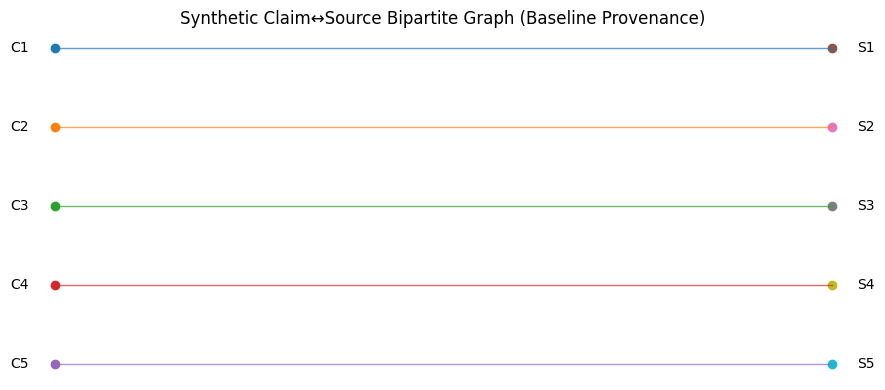

In [4]:
# =========================
# CELL 3 — SYNTHETIC EVIDENCE CORPUS + BASELINE CLAIM GRAPH (CODE-ONLY)
# Advanced contribution: structured evidence anchors + claim-to-source bipartite graph + audit checks
# =========================
TOKEN_RE = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?|[0-9]+(?:\.[0-9]+)?")
STOPWORDS = set("""
a an and are as at be by for from has have if in is it its of on or that the this to was were with without
""".split())

def tokenize(text: str) -> List[str]:
    toks = [t.lower() for t in TOKEN_RE.findall(text)]
    return [t for t in toks if t not in STOPWORDS]

def extract_numbers(text: str) -> List[float]:
    nums = []
    for m in re.finditer(r"\b\d+(?:\.\d+)?\b", text):
        try:
            nums.append(float(m.group(0)))
        except Exception:
            pass
    return nums

@dataclass
class SourceDoc:
    doc_id: str
    title: str
    text: str
    key_facts: Dict[str, Any]

def make_sources() -> List[SourceDoc]:
    # Explicitly synthetic “evidence” with numeric anchors for drift detection.
    # Guard: no real-world entities.
    sources = [
        SourceDoc(
            doc_id="S1",
            title="Synthetic Labor Market Note",
            text=(
                "In the synthetic dataset, January layoffs were recorded at 112000, while job openings were 7200000. "
                "The participation proxy remained stable at 62.1. The note cautions that headline strength can coexist with hidden fragility."
            ),
            key_facts={"layoffs_jan": 112000, "openings": 7200000, "participation": 62.1},
        ),
        SourceDoc(
            doc_id="S2",
            title="Synthetic Credit Conditions Memo",
            text=(
                "The synthetic high-yield spread proxy widened from 3.2 to 4.1 over 8 weeks. "
                "Default-rate proxy was held constant at 1.8. Liquidity conditions were flagged as 'thin' in 3 of 5 weekly snapshots."
            ),
            key_facts={"spread_start": 3.2, "spread_end": 4.1, "weeks": 8, "default_proxy": 1.8, "thin_snapshots": 3},
        ),
        SourceDoc(
            doc_id="S3",
            title="Synthetic Productivity Brief",
            text=(
                "Synthetic output per hour increased 1.4 year-over-year. Unit labor cost proxy increased 2.6. "
                "The brief states that small changes can invert conclusions when chained across revisions."
            ),
            key_facts={"oph_yoy": 1.4, "ulc_proxy": 2.6},
        ),
        SourceDoc(
            doc_id="S4",
            title="Synthetic Inflation Expectations Sheet",
            text=(
                "The 5-year expectation proxy was 2.3 and the 10-year proxy was 2.4. "
                "Survey dispersion proxy declined from 0.9 to 0.7. The sheet notes that dispersion can be lost in paraphrase."
            ),
            key_facts={"exp_5y": 2.3, "exp_10y": 2.4, "disp_start": 0.9, "disp_end": 0.7},
        ),
        SourceDoc(
            doc_id="S5",
            title="Synthetic Corporate Guidance Digest",
            text=(
                "Across 40 synthetic firms, 11 issued downside guidance, 6 issued upside guidance, and the remainder were unchanged. "
                "A caution is included: rewording can smuggle in causal claims not present in the digest."
            ),
            key_facts={"firms": 40, "downside": 11, "upside": 6},
        ),
    ]
    for s in sources:
        assert_no_realworld_text(s.title + " " + s.text, context=f"source:{s.doc_id}")
    return sources

SOURCES = make_sources()
SOURCE_BY_ID = {s.doc_id: s for s in SOURCES}

BASE_CLAIMS = [
    {"claim_id": "C1", "text": "January layoffs were 112000 and job openings were 7200000 in the synthetic record. [cite:S1]", "cite": "S1"},
    {"claim_id": "C2", "text": "The high-yield spread proxy widened from 3.2 to 4.1 over 8 weeks, while default proxy stayed 1.8. [cite:S2]", "cite": "S2"},
    {"claim_id": "C3", "text": "Output per hour rose 1.4 year-over-year and unit labor cost proxy rose 2.6. [cite:S3]", "cite": "S3"},
    {"claim_id": "C4", "text": "Inflation expectation proxies were 2.3 (5-year) and 2.4 (10-year), while dispersion fell from 0.9 to 0.7. [cite:S4]", "cite": "S4"},
    {"claim_id": "C5", "text": "Out of 40 synthetic firms, 11 issued downside guidance and 6 issued upside guidance. [cite:S5]", "cite": "S5"},
]

for c in BASE_CLAIMS:
    assert_no_realworld_text(c["text"], context=f"base_claim:{c['claim_id']}")

# Bipartite adjacency (claims -> sources)
claim_to_source = {c["claim_id"]: c["cite"] for c in BASE_CLAIMS}
source_to_claims = {s.doc_id: [] for s in SOURCES}
for cid, sid in claim_to_source.items():
    source_to_claims[sid].append(cid)

print("Synthetic corpus ready.")
print("Sources:", len(SOURCES), "| Claims:", len(BASE_CLAIMS))
print("Claim→Source mapping:", claim_to_source)

# Lightweight graph visualization (bipartite layout) — no external libs
plt.figure(figsize=(9, 4))
left_x, right_x = 0.2, 0.8
ys_left = np.linspace(0.9, 0.1, len(BASE_CLAIMS))
ys_right = np.linspace(0.9, 0.1, len(SOURCES))

claim_pos = {BASE_CLAIMS[i]["claim_id"]: (left_x, ys_left[i]) for i in range(len(BASE_CLAIMS))}
source_pos = {SOURCES[i].doc_id: (right_x, ys_right[i]) for i in range(len(SOURCES))}

for cid, (x, y) in claim_pos.items():
    plt.scatter([x], [y])
    plt.text(x - 0.02, y, cid, ha="right", va="center")
for sid, (x, y) in source_pos.items():
    plt.scatter([x], [y])
    plt.text(x + 0.02, y, sid, ha="left", va="center")

for cid, sid in claim_to_source.items():
    x1, y1 = claim_pos[cid]
    x2, y2 = source_pos[sid]
    plt.plot([x1, x2], [y1, y2], linewidth=1.0, alpha=0.7)

plt.title("Synthetic Claim↔Source Bipartite Graph (Baseline Provenance)")
plt.axis("off")
fig_path = f"{ARTIFACT_DIR}/fig_p9_claim_source_graph.png"
save_figure(fig_path, title="Baseline provenance graph")

print("Figure saved:", fig_path)


##4.REVISIONS ENGINE

###4.1.OVERVIEW

**CELL 4 — REVISION DYNAMICS ENGINE (ITERATIVE PARAPHRASE + MULTI-CHANNEL DRIFT)**

Cell 4 implements the failure mechanism itself: iterative revision as a process that can gradually detach claims from the sources they purport to summarize. The cell treats revision not as a benign formatting step but as a stochastic transformation with multiple “drift channels,” each corresponding to a real governance vulnerability in interpretive workflows. This is the key methodological decision: evidence drift is rarely a single error; it is the accumulation of small transformations that individually look harmless.

The first channel is paraphrase pressure. By substituting synonyms and altering surface phrasing, the claim can remain plausibly “about” the evidence while progressively losing the exact semantic structure that the evidence supports. The second channel is entity or attribute substitution. This is subtle: swapping “job openings” for “hiring demand,” or “dispersion” for “uncertainty,” can feel like harmless clarification, yet it changes what is being asserted and can change the implied operational meaning. The third channel is numeric perturbation. This simulates the common phenomenon where writers “round,” “smooth,” or rewrite numbers without re-checking. A document can remain fluent and semantically aligned while drifting on the very anchors that make it verifiable.

Two additional channels model governance-critical failures. Citation dropping simulates the decay of explicit provenance: the content might still feel grounded, but the chain of custody is no longer visible. Causal injection simulates interpretive contamination: language that implies causality or attribution can be introduced even though the underlying evidence only supports descriptive statements. This is a canonical failure mode in knowledge work: once causal language appears, downstream readers often treat it as more informative than it is, even if it is unsupported.

Importantly, Cell 4 does not “hide” these risks behind clever abstractions. Each drift channel is parameterized explicitly. That allows the notebook to later run stress regimes in which “revision pressure” and “discipline” are systematically varied. In governance terms, these parameters function like control knobs that represent organizational conditions: the more pressure to shorten, polish, or narrativize, the more likely provenance and factual anchors erode.

Finally, Cell 4 enforces a strict constraint: drift must remain within the synthetic domain. Any revision output is scanned for forbidden real-world patterns. This demonstrates that governance constraints can be enforced as executable checks, not only as policy statements. The overall outcome is a revision engine that is auditable, decomposable, and capable of producing drift that looks realistic in form while remaining strictly controlled in substance.


###4.2.CODE AND IMPLEMENTATION

In [5]:
# =========================
# CELL 4 — REVISION DYNAMICS ENGINE (ITERATIVE PARAPHRASE + MULTI-CHANNEL DRIFT)
# Advanced contribution: separable drift channels + controllable “proxy pressure” knobs + provenance decay
# =========================
SYNONYM_MAP = {
    "recorded": ["noted", "observed", "documented"],
    "widened": ["expanded", "increased", "moved wider"],
    "rose": ["increased", "climbed", "advanced"],
    "fell": ["declined", "decreased", "moved lower"],
    "proxy": ["indicator", "measure", "signal"],
    "synthetic": ["constructed", "simulated", "toy"],
    "cautions": ["warns", "notes", "flags"],
    "while": ["as", "even as", "despite the fact that"],
}

ENTITY_SUBS = [
    ("job openings", "hiring demand"),
    ("high-yield spread", "credit spread"),
    ("default proxy", "default indicator"),
    ("output per hour", "labor productivity"),
    ("unit labor cost", "labor cost measure"),
    ("inflation expectation", "inflation outlook"),
    ("dispersion", "uncertainty"),
    ("downside guidance", "negative guidance"),
    ("upside guidance", "positive guidance"),
]

def paraphrase(text: str, temperature: float) -> str:
    toks = text.split()
    out = []
    for w in toks:
        w_clean = re.sub(r"[^A-Za-z]", "", w).lower()
        if w_clean in SYNONYM_MAP and random.random() < 0.22 * temperature:
            repl = random.choice(SYNONYM_MAP[w_clean])
            out.append(re.sub(re.escape(w_clean), repl, w, flags=re.IGNORECASE))
        else:
            out.append(w)
    return " ".join(out)

def entity_swap(text: str, p: float) -> str:
    t = text
    for a, b in ENTITY_SUBS:
        if random.random() < p:
            t = re.sub(rf"\b{re.escape(a)}\b", b, t, flags=re.IGNORECASE)
    return t

def numeric_perturb(text: str, p: float, max_rel_change: float) -> str:
    def repl(m):
        val = float(m.group(0))
        if random.random() >= p:
            return m.group(0)
        rel = (random.random() * 2.0 - 1.0) * max_rel_change
        new_val = val * (1.0 + rel)
        if m.group(0).isdigit():
            return str(int(round(new_val)))
        return f"{new_val:.1f}"
    return re.sub(r"\b\d+(?:\.\d+)?\b", repl, text)

def maybe_drop_citation(text: str, drop_p: float) -> Tuple[str, bool]:
    if random.random() < drop_p:
        return re.sub(r"\s*\[cite:[A-Za-z0-9]+\]\s*", " ", text).strip(), True
    return text, False

def maybe_add_unsupported_causal(text: str, p: float) -> Tuple[str, bool]:
    # Causal injection not justified by evidence corpus (synthetic failure mode).
    if random.random() < p:
        additions = [
            "This pattern indicates a causal deterioration in conditions.",
            "This change can be attributed to policy tightening.",
            "This result implies a direct weakening of fundamentals.",
        ]
        return (text.rstrip(".") + ". " + random.choice(additions)).strip(), True
    return text, False

@dataclass
class RevisionConfig:
    iterations: int
    temperature: float
    citation_drop_p: float
    entity_swap_p: float
    numeric_perturb_p: float
    numeric_max_rel_change: float
    causal_inject_p: float

def run_revisions(base_claims: List[Dict[str, str]], cfg: RevisionConfig) -> Dict[int, List[Dict[str, Any]]]:
    history: Dict[int, List[Dict[str, Any]]] = {}
    current = [{**c, "dropped_cite": False, "causal_inject": False} for c in base_claims]
    history[0] = current

    for t in range(1, cfg.iterations + 1):
        nxt = []
        for c in current:
            txt = c["text"]
            txt = paraphrase(txt, cfg.temperature)
            txt = entity_swap(txt, cfg.entity_swap_p)
            txt = numeric_perturb(txt, cfg.numeric_perturb_p, cfg.numeric_max_rel_change)
            txt, dropped = maybe_drop_citation(txt, cfg.citation_drop_p)
            txt, causal = maybe_add_unsupported_causal(txt, cfg.causal_inject_p)

            # Governance guard: still must remain “synthetic-only” in content.
            assert_no_realworld_text(txt, context=f"rev_t{t}:{c['claim_id']}")

            nxt.append({
                "claim_id": c["claim_id"],
                "cite": c["cite"],
                "text": txt,
                "dropped_cite": dropped or c.get("dropped_cite", False),
                "causal_inject": causal or c.get("causal_inject", False),
            })
        history[t] = nxt
        current = nxt

    return history

print("Revision dynamics engine ready.")


Revision dynamics engine ready.


##5.EVIDENCE FIDELITY METRICS

###5.1.OVERVIEW

**CELL 5 — EVIDENCE-FIDELITY METRICS (TF-IDF, NUMERIC ANCHORS, PROVENANCE, TAILS)**

Cell 5 builds the measurement system that makes the mechanism legible. Without measurement, evidence drift becomes a subjective complaint about “quality.” This cell rejects that ambiguity by defining multiple integrity metrics that capture different ways a claim can fail to remain disciplined to its source. The point is not to produce a perfect verifier, but to construct an auditable set of signals that reveal why naive evaluation can be misleading.

First, the cell implements a transparent semantic similarity score using TF-IDF vectors and cosine similarity. This creates a baseline notion of “the claim still resembles the source.” But semantic resemblance is only part of evidentiary discipline, so the cell immediately adds orthogonal checks. The numeric consistency check compares the numbers in the claim to the numbers in the source using a nearest-neighbor matching rule and a tolerance threshold. This is intentionally simple: it is easier to audit and reason about than a complex alignment model, and it isolates exactly the failure mode that semantic similarity can miss. A claim can be semantically close yet numerically wrong.

Next, the provenance layer is measured via citation marker presence. The experiment distinguishes two states: content that still carries an explicit citation marker and content that does not. The difference matters because governance is not only about correctness; it is about traceability. A claim that is likely correct but lacks provenance can still be operationally risky because it cannot be verified efficiently by reviewers.

The cell also flags causal language with a lexical rule. This is not a perfect detector, but it is enough to operationalize “interpretive drift” as a measurable event. The aim is to show that under revision pressure, documents can acquire causal implications that were never supported by evidence, even if the rest of the sentence remains plausible.

Crucially, Cell 5 makes tail behavior first-class. It computes a tail drift statistic focusing on the worst-performing portion of claims rather than averaging everything into a single mean. This is a governance-aligned choice: many institutional failures are driven by a few bad outputs rather than the average output. If evaluation only looks at means, it can miss rare but consequential detachments.

Finally, the cell outputs both per-claim diagnostics and aggregate summaries. That separation mirrors how audits work: summary metrics can show trends, but per-claim records allow reviewers to inspect exactly where and how failures occurred. By the end of Cell 5, the notebook has an explicit multi-metric definition of evidentiary discipline, setting up the core demonstration: one metric can look stable while other integrity dimensions collapse.


###5.2.CODE AND IMPLEMENTATION

In [6]:
# =========================
# CELL 5 — EVIDENCE-FIDELITY METRICS (TF-IDF, NUMERIC ANCHORS, PROVENANCE, TAILS)
# Advanced contribution: multi-metric regime + tail diagnostics + “quiet failure” detection logic
# =========================
def l2_normalize(v: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    n = float(np.linalg.norm(v))
    return v / (n + eps)

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.dot(l2_normalize(a), l2_normalize(b)))

def build_vocab(texts: List[str], min_df: int = 1) -> Dict[str, int]:
    df = {}
    for tx in texts:
        seen = set(tokenize(tx))
        for tok in seen:
            df[tok] = df.get(tok, 0) + 1
    vocab = {}
    for tok, c in df.items():
        if c >= min_df:
            vocab[tok] = len(vocab)
    return vocab

def tfidf_matrix(texts: List[str], vocab: Dict[str, int]) -> np.ndarray:
    N, V = len(texts), len(vocab)
    tf = np.zeros((N, V), dtype=float)
    df = np.zeros((V,), dtype=float)

    tokenized = []
    for i, tx in enumerate(texts):
        toks = tokenize(tx)
        tokenized.append(toks)
        counts = {}
        for tok in toks:
            if tok in vocab:
                j = vocab[tok]
                counts[j] = counts.get(j, 0) + 1
        for j, cnt in counts.items():
            tf[i, j] = cnt
        for tok in set(toks):
            if tok in vocab:
                df[vocab[tok]] += 1.0

    tf = np.log1p(tf)
    idf = np.log((N + 1.0) / (df + 1.0)) + 1.0
    return tf * idf

def claim_cites_present(claim_text: str) -> bool:
    return bool(re.search(r"\[cite:[A-Za-z0-9]+\]", claim_text))

def cited_doc_text(cite_id: str) -> str:
    return SOURCE_BY_ID[cite_id].text

def numeric_consistency(claim_text: str, source_text: str, tol_rel: float = 0.02) -> Dict[str, Any]:
    cn = sorted(extract_numbers(claim_text))
    sn = sorted(extract_numbers(source_text))
    if len(cn) == 0 or len(sn) == 0:
        return {"has_numbers_claim": len(cn) > 0, "has_numbers_source": len(sn) > 0, "match_rate": None, "matches": []}

    matches = []
    used = set()
    for x in cn:
        best_j, best_err = None, None
        for j, y in enumerate(sn):
            if j in used:
                continue
            denom = max(abs(y), 1.0)
            err = abs(x - y) / denom
            if best_err is None or err < best_err:
                best_err, best_j = err, j
        if best_j is not None:
            used.add(best_j)
            matches.append({"claim": x, "source": sn[best_j], "rel_err": best_err, "ok": best_err <= tol_rel})

    ok = [m["ok"] for m in matches]
    match_rate = float(np.mean(ok)) if len(ok) else None
    return {"has_numbers_claim": True, "has_numbers_source": True, "match_rate": match_rate, "matches": matches}

def evidence_term_coverage(claim_text: str, source_text: str, top_k: int = 12) -> float:
    s_toks = tokenize(source_text)
    if not s_toks:
        return float("nan")
    freq = {}
    for t in s_toks:
        freq[t] = freq.get(t, 0) + 1
    top = sorted(freq.items(), key=lambda kv: (-kv[1], kv[0]))[:top_k]
    top_terms = set([k for k, _ in top])
    c_terms = set(tokenize(claim_text))
    if not top_terms:
        return float("nan")
    return len(top_terms & c_terms) / len(top_terms)

def causal_language_flag(claim_text: str) -> bool:
    return bool(re.search(r"\b(causal|attributed|implies|indicates|due to|because)\b", claim_text, flags=re.IGNORECASE))

def compute_metrics_for_iteration(claims: List[Dict[str, Any]]) -> Dict[str, Any]:
    texts = []
    pairs = []
    for c in claims:
        stext = cited_doc_text(c["cite"])
        texts.append(c["text"])
        texts.append(stext)
        pairs.append((len(texts) - 2, len(texts) - 1))

    vocab = build_vocab(texts, min_df=1)
    X = tfidf_matrix(texts, vocab)

    per_claim = []
    for c, (i_claim, i_src) in zip(claims, pairs):
        sim = cosine_sim(X[i_claim], X[i_src])
        drift = 1.0 - sim
        num = numeric_consistency(c["text"], texts[i_src])
        coverage = evidence_term_coverage(c["text"], texts[i_src])
        per_claim.append({
            "claim_id": c["claim_id"],
            "cite": c["cite"],
            "tfidf_cosine_similarity": sim,
            "drift_index": drift,
            "has_explicit_citation_marker": claim_cites_present(c["text"]),
            "numeric_match_rate": num["match_rate"],
            "numeric_matches": num["matches"][:6],
            "evidence_term_coverage": coverage,
            "causal_language_flag": causal_language_flag(c["text"]),
            "dropped_cite_flag": bool(c.get("dropped_cite", False)),
            "causal_inject_flag": bool(c.get("causal_inject", False)),
        })

    sims = np.array([pc["tfidf_cosine_similarity"] for pc in per_claim], dtype=float)
    drifts = np.array([pc["drift_index"] for pc in per_claim], dtype=float)

    q80 = float(np.quantile(drifts, 0.80))
    tail = drifts[drifts >= q80]
    tail_mean = float(np.mean(tail)) if len(tail) else float("nan")

    cite_rate = float(np.mean([pc["has_explicit_citation_marker"] for pc in per_claim])) if per_claim else float("nan")

    nm = [pc["numeric_match_rate"] for pc in per_claim if pc["numeric_match_rate"] is not None]
    numeric_mean = float(np.mean(nm)) if nm else None

    causal_rate = float(np.mean([pc["causal_language_flag"] for pc in per_claim])) if per_claim else float("nan")

    return {
        "per_claim": per_claim,
        "summary": {
            "mean_similarity": float(np.mean(sims)),
            "min_similarity": float(np.min(sims)),
            "mean_drift": float(np.mean(drifts)),
            "max_drift": float(np.max(drifts)),
            "tail_mean_drift_worst20pct": tail_mean,
            "citation_marker_rate": cite_rate,
            "numeric_match_rate_mean": numeric_mean,
            "causal_language_flag_rate": causal_rate,
        }
    }

print("Metrics module ready.")


Metrics module ready.


##6.CORE RUN

###6.1.OVERVIEW

**CELL 6 — CORE RUN: DRIFT OVER ITERATIONS + COMPACT DIAGNOSTICS**

Cell 6 executes the controlled experiment under a single “core” revision regime. The purpose is to generate a time-evolving trajectory of drift rather than a one-shot comparison. This matters because evidence drift is typically not an instantaneous failure; it is the emergent property of repeated transformation. In practical knowledge workflows, documents often pass through multiple hands, multiple tools, and multiple rounds of “improvement.” This cell recreates that iterative structure.

The cell runs the revision engine for a fixed number of iterations and computes the full integrity metric suite at every iteration. The result is a longitudinal dataset: at each step, you have semantic similarity, citation visibility, numeric anchor integrity, causal-language contamination, and tail drift. This enables a governance-relevant analysis that is fundamentally different from typical model evaluation. Instead of asking “how good is the output,” it asks “how does integrity evolve under repeated processing.”

Cell 6 then provides compact diagnostics to surface the most detached claims at the final iteration. This is not merely a convenience. In an audit setting, a single worst-case example can be more informative than an average score because it reveals the actual failure phenotype: what the drift looks like in text form, how citations disappear, how numbers distort, and how causal implications appear. The cell is careful to keep printed output small and interpretable, which is itself a governance choice: large logs are difficult to review and easy to ignore.

The cell also performs explicit governance sanity checks. It re-validates that all revised text remains within the synthetic-only constraint. This is important because the revision engine is stochastic; even in a synthetic notebook, guardrails must be enforced continuously, not assumed once. The cell’s checks demonstrate that governance can be embedded into the experimental runtime: violations become runtime failures rather than footnotes.

In conceptual terms, Cell 6 establishes the baseline phenomenon: under moderate revision pressure, integrity metrics shift over time. It sets up the core tension that the rest of the notebook will sharpen: surface-level resemblance can remain plausible while hidden integrity dimensions degrade. This is the central point for interpretive AI under evidentiary discipline: what feels “better written” can become less auditable, less verifiable, and less faithful, and that shift can occur gradually enough that naive reviewers do not notice until late in the process.


###6.2.CODE AND IMPLEMENTATION

In [7]:
# =========================
# CELL 6 — CORE RUN: DRIFT OVER ITERATIONS + COMPACT DIAGNOSTICS (CODE-ONLY)
# =========================
core_cfg = RevisionConfig(
    iterations=18,
    temperature=1.35,
    citation_drop_p=0.12,
    entity_swap_p=0.10,
    numeric_perturb_p=0.18,
    numeric_max_rel_change=0.08,
    causal_inject_p=0.10,
)

history = run_revisions(BASE_CLAIMS, core_cfg)

metrics_by_t = {}
for t in sorted(history.keys()):
    metrics_by_t[t] = compute_metrics_for_iteration(history[t])

T = core_cfg.iterations
print("Core run complete.")
print("Final iteration:", T)
print("Final summary:", json.dumps(metrics_by_t[T]["summary"], indent=2))

final_per = metrics_by_t[T]["per_claim"]
worst = sorted(final_per, key=lambda x: -x["drift_index"])[:2]
print("\nWorst-drift claims @ final iteration (compact):")
for w in worst:
    print(f"- {w['claim_id']} cite={w['cite']} drift={w['drift_index']:.3f} sim={w['tfidf_cosine_similarity']:.3f} "
          f"cite_marker={w['has_explicit_citation_marker']} num_match={w['numeric_match_rate']} causal_flag={w['causal_language_flag']}")

# Basic governance sanity: verify synthetic-only maintained
for t in (0, T):
    for c in history[t]:
        assert_no_realworld_text(c["text"], context=f"sanity:t{t}:{c['claim_id']}")

print("\nGovernance sanity checks passed (synthetic-only content maintained).")


Core run complete.
Final iteration: 18
Final summary: {
  "mean_similarity": 0.2213401094948675,
  "min_similarity": 0.10475463174771345,
  "mean_drift": 0.7786598905051325,
  "max_drift": 0.8952453682522865,
  "tail_mean_drift_worst20pct": 0.8952453682522865,
  "citation_marker_rate": 0.2,
  "numeric_match_rate_mean": 0.4333333333333333,
  "causal_language_flag_rate": 1.0
}

Worst-drift claims @ final iteration (compact):
- C1 cite=S1 drift=0.895 sim=0.105 cite_marker=False num_match=0.5 causal_flag=True
- C3 cite=S3 drift=0.796 sim=0.204 cite_marker=True num_match=0.0 causal_flag=True

Governance sanity checks passed (synthetic-only content maintained).


##7.STRESS TEST

###7.1.OVERVIEW

**CELL 7 — STRESS SUITE: MULTI-REGIME COMPARISON + SINGLE-METRIC TRAP**

Cell 7 extends the experiment from a single run into a comparative stress suite. The purpose is to show that evidence drift is not an invariant phenomenon; it depends systematically on “pressure” and “discipline” parameters. This mirrors real institutional conditions: some workflows preserve citations and numeric anchors aggressively, while others prioritize readability and narrative coherence.

The stress suite defines multiple regimes with different levels of paraphrase intensity, citation dropping probability, numeric perturbation probability, and causal injection probability. These regimes function as synthetic analogues of organizational environments. For instance, a high-discipline regime models a workflow with rigorous editorial standards and provenance enforcement. A low-discipline regime models a workflow where speed, polish, and simplification dominate, and where provenance is treated as optional rather than mandatory.

The key analytic deliverable in this cell is the demonstration of a single-metric trap. The cell explicitly ranks regimes by mean semantic similarity, which is the kind of metric a naive evaluator might use. Then it juxtaposes that ranking with tail drift, showing that the regime that looks “best” by a single average metric may still exhibit severe tail failures. This is the governance point: institutional risk is often driven by the tails, not by the mean. If evaluation focuses on one broad score, it can systematically underestimate risk.

Cell 7 also introduces the “quiet failure” concept operationally. Quiet failures are cases where semantic similarity is relatively high—so the text looks aligned—but integrity failures occur via citation loss, numeric mismatch, or causal contamination. These are the failures that are hardest to catch by casual review. In practice, reviewers often rely on plausibility and surface resemblance; quiet failures exploit that reliance. By detecting and listing quiet failures in each regime, the cell creates a concrete bridge from abstract metrics to inspectable cases.

Overall, Cell 7 transforms the notebook from a descriptive demonstration into a structured argument about evaluation: drift is regime-dependent, single metrics are insufficient, and tails plus provenance indicators are necessary to capture what matters in interpretive knowledge work. It does this without introducing heavy theory, relying instead on controlled synthetic variation and transparent diagnostics.


###7.2.CODE AND IMPLEMENTATION

In [8]:
# =========================
# CELL 7 — STRESS SUITE: MULTI-REGIME COMPARISON + SINGLE-METRIC TRAP (CODE-ONLY)
# =========================
stress_configs = {
    "LowPressure_HighDiscipline": RevisionConfig(
        iterations=T, temperature=0.70, citation_drop_p=0.02, entity_swap_p=0.04,
        numeric_perturb_p=0.05, numeric_max_rel_change=0.03, causal_inject_p=0.02,
    ),
    "HighPressure_MixedDiscipline": RevisionConfig(
        iterations=T, temperature=1.60, citation_drop_p=0.12, entity_swap_p=0.12,
        numeric_perturb_p=0.20, numeric_max_rel_change=0.10, causal_inject_p=0.12,
    ),
    "HighPressure_LowDiscipline": RevisionConfig(
        iterations=T, temperature=1.80, citation_drop_p=0.25, entity_swap_p=0.16,
        numeric_perturb_p=0.28, numeric_max_rel_change=0.14, causal_inject_p=0.18,
    ),
}

stress_results = {}
for name, cfg in stress_configs.items():
    h = run_revisions(BASE_CLAIMS, cfg)
    m = {t: compute_metrics_for_iteration(h[t]) for t in sorted(h.keys())}
    stress_results[name] = {"config": cfg.__dict__, "metrics_by_t": m}

def final_summary(name: str) -> dict:
    return stress_results[name]["metrics_by_t"][T]["summary"]

print("Stress suite final summaries:")
for name in stress_configs:
    s = final_summary(name)
    print(f"- {name}: mean_sim={s['mean_similarity']:.3f}, tail_drift={s['tail_mean_drift_worst20pct']:.3f}, "
          f"cite_rate={s['citation_marker_rate']:.2f}, numeric_mean={s['numeric_match_rate_mean']}, causal_rate={s['causal_language_flag_rate']:.2f}")

# Single-metric trap: rank by mean_similarity (naively “good”), then display tail drift
rank = sorted([(n, final_summary(n)["mean_similarity"], final_summary(n)["tail_mean_drift_worst20pct"]) for n in stress_configs],
              key=lambda x: -x[1])
print("\nSingle-metric trap ranking (by mean similarity):")
for n, ms, td in rank:
    print(f"  {n:28s} mean_similarity={ms:.3f} | tail_mean_drift(worst20%)={td:.3f}")

# “Quiet failure” indicator: claims with above-median similarity but provenance or numeric issues
quiet_by_regime = {}
for name in stress_configs:
    per = stress_results[name]["metrics_by_t"][T]["per_claim"]
    med_sim = float(np.median([p["tfidf_cosine_similarity"] for p in per]))
    quiet = []
    for p in per:
        if p["tfidf_cosine_similarity"] >= med_sim:
            if (p["numeric_match_rate"] is not None and p["numeric_match_rate"] < 0.6) or p["dropped_cite_flag"] or p["causal_inject_flag"]:
                quiet.append(p["claim_id"])
    quiet_by_regime[name] = quiet

print("\nQuiet-failure claim IDs by regime (above-median similarity but integrity failure):")
for name, q in quiet_by_regime.items():
    print(f"- {name}: {q}")


Stress suite final summaries:
- LowPressure_HighDiscipline: mean_sim=0.323, tail_drift=0.883, cite_rate=0.60, numeric_mean=1.0, causal_rate=0.40
- HighPressure_MixedDiscipline: mean_sim=0.195, tail_drift=0.906, cite_rate=0.20, numeric_mean=0.35, causal_rate=0.80
- HighPressure_LowDiscipline: mean_sim=0.137, tail_drift=0.931, cite_rate=0.00, numeric_mean=0.05, causal_rate=1.00

Single-metric trap ranking (by mean similarity):
  LowPressure_HighDiscipline   mean_similarity=0.323 | tail_mean_drift(worst20%)=0.883
  HighPressure_MixedDiscipline mean_similarity=0.195 | tail_mean_drift(worst20%)=0.906
  HighPressure_LowDiscipline   mean_similarity=0.137 | tail_mean_drift(worst20%)=0.931

Quiet-failure claim IDs by regime (above-median similarity but integrity failure):
- LowPressure_HighDiscipline: ['C3', 'C5']
- HighPressure_MixedDiscipline: ['C2', 'C3', 'C5']
- HighPressure_LowDiscipline: ['C2', 'C3', 'C5']


##8.VISUAL ANALYTICS

###8.1.OVERVIEW

**CELL 8 — VISUAL ANALYTICS (TAILS, TRAJECTORIES, HEATMAPS) + FIGURE SAVING**

Cell 8 is the interpretability layer of the experiment. It converts the metric time series and regime comparisons into visual objects that are easy to audit. This is not about aesthetics; it is about making failure modes visible in ways that do not require reading dense logs. In governance work, visibility is a control: if reviewers cannot see integrity decay, they cannot reliably act as a check on it.

The cell produces multiple trajectory plots for the core run. Mean similarity over time shows how surface-level resemblance evolves. Tail drift over time shows whether the worst-case detachments are growing faster than the average. Citation marker rate shows whether provenance is being preserved or quietly decaying. Causal-language flag rate shows whether interpretive contamination is increasing as revisions accumulate. By placing these signals on time axes, the plots reveal whether integrity decay is monotonic, whether it accelerates, and whether different integrity channels diverge. That divergence is central: a stable semantic line alongside a collapsing citation line is precisely the kind of misleading comfort that naive evaluation can produce.

The cell then creates a scatter plot comparing regimes by mean similarity and tail drift at the final iteration. This visualization makes the single-metric trap intuitive: points can sit in a region that appears “good” on average while still occupying a high-risk tail zone. The plot is a compact diagnostic tool: one image captures why “one number” is a governance failure.

Finally, the similarity heatmap provides a claim-level provenance diagnostic. Even though each claim is supposed to map to one source, the heatmap shows how similarity distributes across all sources. This matters because drift can cause a claim to resemble the wrong source more than its cited source, creating a subtle category of failure: the citation points one way, but the language aligns elsewhere. The heatmap therefore reveals misalignment patterns that a single similarity score cannot.

A critical governance feature in this cell is that all figures are saved and registered in the run manifest with hashes. The figures are not ephemeral. They become audit artifacts that can be referenced, re-checked, and compared across runs. The cell thus completes a standard audit loop: measurement produces interpretable evidence objects, and those objects become durable artifacts in an auditable record.


###8.2.CODE AND IMPLEMENTATION

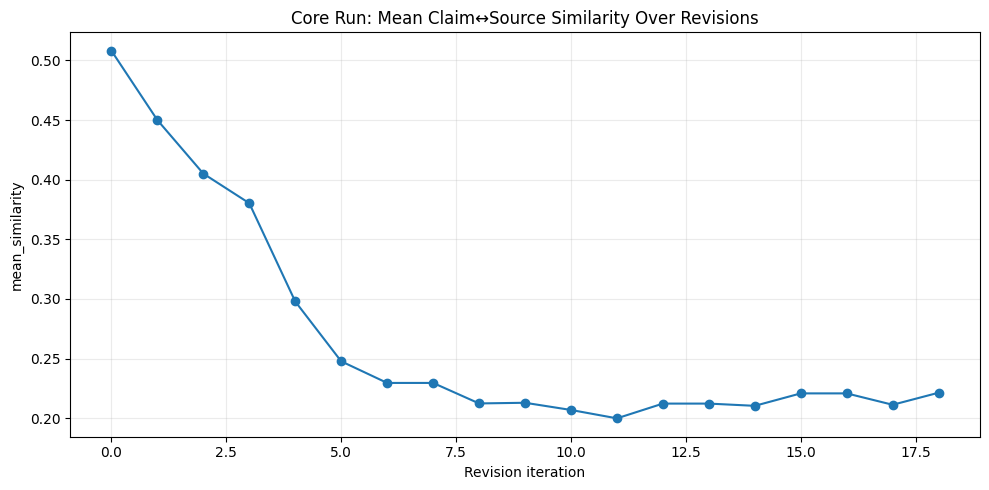

Saved: /mnt/data/fig_p9_core_mean_similarity.png


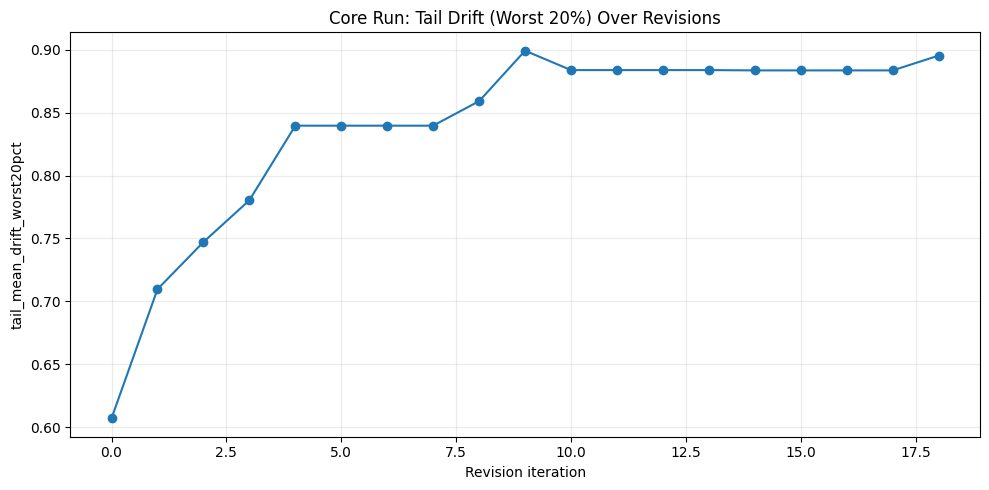

Saved: /mnt/data/fig_p9_core_tail_drift.png


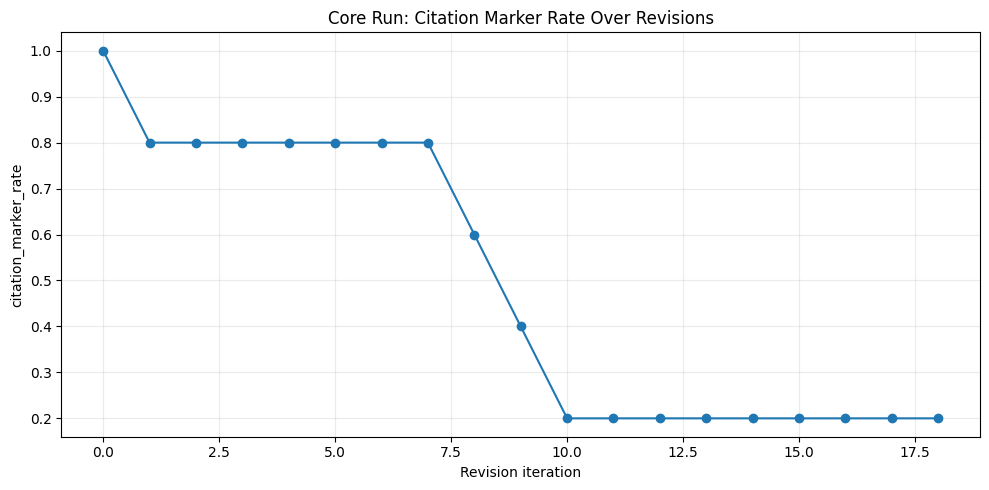

Saved: /mnt/data/fig_p9_core_citation_rate.png


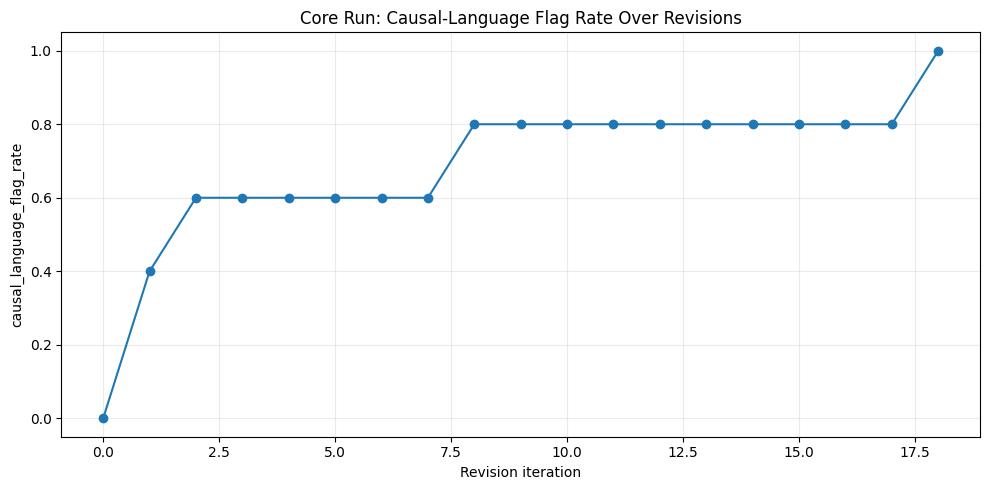

Saved: /mnt/data/fig_p9_core_causal_flag_rate.png


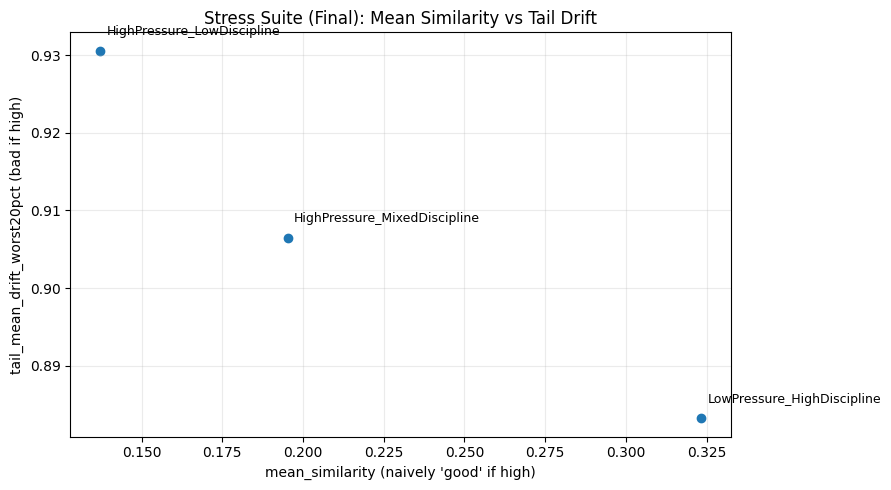

Saved: /mnt/data/fig_p9_stress_scatter.png


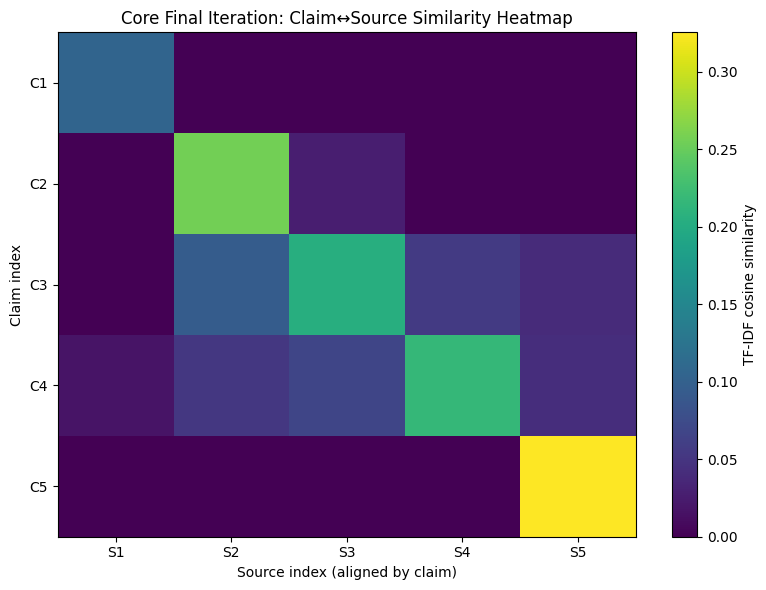

Saved: /mnt/data/fig_p9_core_heatmap.png
Cell 8 complete (visual analytics saved + registered in manifest).


In [9]:
# =========================
# CELL 8 — VISUAL ANALYTICS (TAILS, TRAJECTORIES, HEATMAPS) + FIGURE SAVING (CODE-ONLY)
# =========================
def plot_series(metric_key: str, title: str, out_name: str):
    plt.figure(figsize=(10, 5))
    ts = [metrics_by_t[t]["summary"][metric_key] for t in sorted(metrics_by_t.keys())]
    plt.plot(sorted(metrics_by_t.keys()), ts, marker="o", linewidth=1.5)
    plt.title(title)
    plt.xlabel("Revision iteration")
    plt.ylabel(metric_key)
    plt.grid(True, alpha=0.25)
    path = f"{ARTIFACT_DIR}/{out_name}"
    save_figure(path, title=title)
    plt.show()
    print("Saved:", path)

plot_series("mean_similarity", "Core Run: Mean Claim↔Source Similarity Over Revisions", "fig_p9_core_mean_similarity.png")
plot_series("tail_mean_drift_worst20pct", "Core Run: Tail Drift (Worst 20%) Over Revisions", "fig_p9_core_tail_drift.png")
plot_series("citation_marker_rate", "Core Run: Citation Marker Rate Over Revisions", "fig_p9_core_citation_rate.png")
plot_series("causal_language_flag_rate", "Core Run: Causal-Language Flag Rate Over Revisions", "fig_p9_core_causal_flag_rate.png")

# Stress scatter: mean similarity vs tail drift (final iteration)
plt.figure(figsize=(9, 5))
xs, ys, labels = [], [], []
for name in stress_configs:
    s = stress_results[name]["metrics_by_t"][T]["summary"]
    xs.append(s["mean_similarity"])
    ys.append(s["tail_mean_drift_worst20pct"])
    labels.append(name)

plt.scatter(xs, ys)
for x, y, lab in zip(xs, ys, labels):
    plt.text(x + 0.002, y + 0.002, lab, fontsize=9)

plt.title("Stress Suite (Final): Mean Similarity vs Tail Drift")
plt.xlabel("mean_similarity (naively 'good' if high)")
plt.ylabel("tail_mean_drift_worst20pct (bad if high)")
plt.grid(True, alpha=0.25)
scatter_path = f"{ARTIFACT_DIR}/fig_p9_stress_scatter.png"
save_figure(scatter_path, title="Stress: mean similarity vs tail drift")
plt.show()
print("Saved:", scatter_path)

# Heatmap: claim->source similarity matrix at final iteration (core)
final_claims = history[T]
claim_texts = [c["text"] for c in final_claims]
src_texts = [cited_doc_text(c["cite"]) for c in final_claims]
texts = claim_texts + src_texts
vocab = build_vocab(texts)
X = tfidf_matrix(texts, vocab)

H = np.zeros((len(final_claims), len(final_claims)), dtype=float)
for i in range(len(final_claims)):
    for j in range(len(final_claims)):
        H[i, j] = cosine_sim(X[i], X[len(final_claims) + j])

plt.figure(figsize=(8, 6))
plt.imshow(H, aspect="auto")
plt.title("Core Final Iteration: Claim↔Source Similarity Heatmap")
plt.xlabel("Source index (aligned by claim)")
plt.ylabel("Claim index")
plt.colorbar(label="TF-IDF cosine similarity")
plt.xticks(range(len(final_claims)), [c["cite"] for c in final_claims])
plt.yticks(range(len(final_claims)), [c["claim_id"] for c in final_claims])
heat_path = f"{ARTIFACT_DIR}/fig_p9_core_heatmap.png"
save_figure(heat_path, title="Core final heatmap")
plt.show()
print("Saved:", heat_path)

print("Cell 8 complete (visual analytics saved + registered in manifest).")


##9.AUDIT PAYLOAD

###9.1.0VERVIEW

**CELL 9 — AUTHORITATIVE AUDIT PAYLOAD JSON (INPUT TO CELL 10) + MANIFEST UPDATE**

Cell 9 is the boundary between computation and interpretation. It packages the experiment into a structured payload that becomes the sole authorized input to the LLM in Cell 10. This is a governance design pattern: interpretive systems are constrained by structured evidence, not free-form reading of the notebook state. By enforcing this boundary, the notebook reduces the risk that the LLM invents results or selectively emphasizes what happens to be printed on screen.

The payload includes the experiment configuration, objective specification, results time series, final iteration summaries, per-claim diagnostics, stress suite contrasts, and a compact trace excerpt showing how claims evolve across snapshots. This payload is not merely a report; it is the ground truth contract. The LLM is instructed to treat it as authoritative, and to avoid speculation beyond it. In an audit-grade workflow, this is analogous to requiring that narratives be derived from a defined evidence bundle, not from informal memory.

A key feature is the inclusion of multiple metrics and tail statistics, explicitly pre-computed. The payload does not rely on the LLM to compute or infer metrics; it provides them. This reduces the risk of computational mistakes and ensures that interpretation is anchored to fixed numbers that reviewers can check. The payload also includes “quiet failure” IDs, which are a governance-oriented diagnostic: they highlight cases where naive semantic checks can be fooled.

Cell 9 also adds integrity metadata: it computes a deterministic hash of the canonical payload representation. This is an audit mechanism. It allows downstream reviewers to verify that the payload consumed by the LLM is exactly the payload produced by the notebook, without silent modification. The payload file is saved to disk, and it is registered in the run manifest with its own hash. This produces a chain of custody: the run has a manifest, the manifest points to the payload, and the payload is hash-addressable.

Conceptually, Cell 9 enforces evidentiary discipline on the interpretation step itself. It demonstrates that even if you use an LLM to write a narrative audit artifact, governance does not require banning the model; it requires constraining it to a structured evidence interface, logging the interface, and enabling verification of what was provided versus what was produced.


###9.2.CODE AND IMPLEMENTATION

In [12]:
# =========================
# CELL 9 — AUTHORITATIVE AUDIT PAYLOAD JSON (FIXED) + MANIFEST UPDATE
# (Fix: compute payload_hash AFTER payload exists; avoid self-referential hashing.)
# =========================
import json, hashlib
import numpy as np

# Preconditions
assert "RUN_ID" in globals()
assert "SEED" in globals()
assert "core_cfg" in globals()
assert "stress_configs" in globals()
assert "stress_results" in globals()
assert "SOURCES" in globals()
assert "BASE_CLAIMS" in globals()
assert "T" in globals()
assert "metrics_by_t" in globals()
assert "history" in globals()
assert "MANIFEST_PATH" in globals()
assert "register_artifact" in globals()
assert "ARTIFACT_DIR" in globals()

def stable_hash_str(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()[:16]

objective_spec = {
    "proxy_objective": "Increase perceived fluency/compactness under repeated revision (synthetic pressure).",
    "true_objective": "Preserve evidence fidelity (semantic + numeric) and explicit provenance markers.",
    "constrained_objective": "True objective subject to constraints on citation retention, numeric anchor stability, and causal-language injection.",
    "constraints": [
        "Preserve explicit citation markers",
        "Avoid unsupported causal language",
        "Maintain numeric anchors within tolerance where present",
    ],
    "note": "This notebook simulates revision pressure rather than performing optimization."
}

final_per_claim = metrics_by_t[T]["per_claim"]
med_sim = float(np.median([p["tfidf_cosine_similarity"] for p in final_per_claim]))

quiet_failures = []
for p in final_per_claim:
    if p["tfidf_cosine_similarity"] >= med_sim:
        if (p["numeric_match_rate"] is not None and p["numeric_match_rate"] < 0.6) or p["dropped_cite_flag"] or p["causal_inject_flag"]:
            quiet_failures.append(p["claim_id"])

def summarize_traces(history_obj, snapshots):
    trace = {}
    for base in history_obj[0]:
        cid = base["claim_id"]
        trace[cid] = []
        for t in snapshots:
            ct = [x for x in history_obj[t] if x["claim_id"] == cid][0]["text"]
            trace[cid].append({"t": t, "text_excerpt": ct[:260] + ("..." if len(ct) > 260 else "")})
    return {"snapshots": snapshots, "claim_traces_excerpt": trace}

stress_contrast = {name: stress_results[name]["metrics_by_t"][T]["summary"] for name in stress_configs}

payload = {
    "governance_disclaimer": "Synthetic, illustrative, and NOT validated for real-world use. Not a decision tool.",
    "experiment_name": "Evidence Drift Under Iterative Revision (Synthetic)",
    "run_id": RUN_ID,
    "config": {
        "seed": SEED,
        "core_revision_config": core_cfg.__dict__,
        "stress_suite_configs": {k: v.__dict__ for k, v in stress_configs.items()},
        "n_sources": len(SOURCES),
        "n_claims": len(BASE_CLAIMS),
        "iterations": T,
        "manifest_path": MANIFEST_PATH,
    },
    "objectives": objective_spec,
    "results": {
        "core_time_series_summary": {
            "t": sorted(metrics_by_t.keys()),
            "mean_similarity": [metrics_by_t[t]["summary"]["mean_similarity"] for t in sorted(metrics_by_t.keys())],
            "tail_mean_drift_worst20pct": [metrics_by_t[t]["summary"]["tail_mean_drift_worst20pct"] for t in sorted(metrics_by_t.keys())],
            "citation_marker_rate": [metrics_by_t[t]["summary"]["citation_marker_rate"] for t in sorted(metrics_by_t.keys())],
            "causal_language_flag_rate": [metrics_by_t[t]["summary"]["causal_language_flag_rate"] for t in sorted(metrics_by_t.keys())],
        },
        "final_iteration_summary": metrics_by_t[T]["summary"],
        "final_per_claim_metrics": final_per_claim,
        "quiet_failures_claim_ids": quiet_failures,
        "stress_suite_final_summaries": stress_contrast,
    },
    "diagnostics": {
        "trace_excerpt": summarize_traces(history, snapshots=[0, T // 2, T]),
        "notes": [
            "TF-IDF similarity is a coarse semantic proxy; mean similarity can remain moderate while integrity fails in tails.",
            "Numeric anchor checks isolate drift that can be masked by paraphrase-level semantic overlap.",
            "Citation marker loss and causal-language injection represent provenance and interpretive integrity failures.",
        ]
    },
}

# Hash the payload deterministically (WITHOUT the integrity field itself)
payload_canonical = json.dumps(payload, sort_keys=True, separators=(",", ":"))
payload_hash = stable_hash_str(payload_canonical)

payload["integrity"] = {
    "payload_hash": payload_hash,
    "payload_canonical_sha256_full": hashlib.sha256(payload_canonical.encode("utf-8")).hexdigest(),
}

payload_path = f"{ARTIFACT_DIR}/paper9_audit_payload.json"
with open(payload_path, "w") as f:
    json.dump(payload, f, indent=2)

register_artifact("payload", payload_path)

print("Audit payload written:", payload_path)
print("Payload hash (short):", payload_hash)
print("Payload sha256 (full):", payload["integrity"]["payload_canonical_sha256_full"])
print("\nFinal iteration summary (compact):")
print(json.dumps(payload["results"]["final_iteration_summary"], indent=2))


Audit payload written: /mnt/data/paper9_audit_payload.json
Payload hash (short): 9a1f4ab554f2de39
Payload sha256 (full): 9a1f4ab554f2de39a50fb3422e12294a3815a4cf7c459e6fde26f70a97d6b00f

Final iteration summary (compact):
{
  "mean_similarity": 0.2213401094948675,
  "min_similarity": 0.10475463174771345,
  "mean_drift": 0.7786598905051325,
  "max_drift": 0.8952453682522865,
  "tail_mean_drift_worst20pct": 0.8952453682522865,
  "citation_marker_rate": 0.2,
  "numeric_match_rate_mean": 0.4333333333333333,
  "causal_language_flag_rate": 1.0
}


##10.AUDIT REPORT

###10.1.OVERVIEW

**CELL 10 — INTELLIGENT AUDIT REPORT (LLM) WITH POST-GENERATION GOVERNANCE SCANS**

Cell 10 generates the interpretive layer as an explicit audit artifact. The cell is intentionally isolated as the only location where an LLM is invoked, reflecting a governance constraint: tool use must be localized, inspectable, and controllable. The cell begins by installing and initializing the required client library and loading the payload produced in Cell 9. This design ensures that the model is not “reading the notebook”; it is reading a defined evidence bundle whose contents are already logged and hashable.

The system prompt enforces a strict reporting format and strict behavioral constraints. The report must explicitly state that the experiment is synthetic and not validated for real-world use. It must avoid advice, recommendations, and deployment guidance. It must avoid prescriptive language. Most importantly, it must base claims strictly on the provided payload and must not invent facts. The report structure is fixed into six sections that mirror an audit-style review: executive summary, methods/objectives, findings, tail risks, governance interpretation, and limitations/validation requirements. This structure is not rhetorical; it is a control mechanism that reduces the chance of drifting into narrative flourish or informal commentary.

After generation, the cell performs post-generation governance scans on the report text. This is a crucial advanced element. Instead of trusting the model to comply, it enforces compliance by checking for prohibited real-world patterns and prohibited prescriptive language. The logic is simple but effective: if violations appear, the cell fails fast, preventing the creation of a non-compliant artifact. In institutional practice, this resembles automated policy gates that block outputs that violate constraints, regardless of how persuasive they appear.

The report is saved as a durable artifact and registered into the run manifest with a hash. This closes the audit loop: inputs are hashed and logged, outputs are hashed and logged, and the linkage between them is anchored by the run manifest. A reviewer can examine the payload, verify its hash, examine the report, verify its hash, and reproduce the run with the same seed and parameters to test stability. This is the core governance message of Paper 9 as implemented in code: interpretive AI can be made more disciplined not by suppressing narrative generation, but by constraining narrative generation to auditable evidence interfaces and by enforcing post-generation controls that reduce the risk of epistemic drift.


###10.2.CODE AND IMPLEMENTATION

In [13]:
# =========================
# CELL 10 — INTELLIGENT AUDIT REPORT (MANDATORY LLM CALL; ONLY CELL WITH LLM)
# Non-negotiable: model="claude-haiku-4-5-20251001" + install anthropic
# Advanced contribution: strict grounding + post-generation governance scan + artifact registration
# =========================
!pip -q install anthropic

import anthropic
from google.colab import userdata

MODEL_NAME = "claude-haiku-4-5-20251001"

api_key = userdata.get("ANTHROPIC_API_KEY")
if not api_key:
    raise RuntimeError("Missing ANTHROPIC_API_KEY in Colab userdata. Set it via Colab > Secrets.")

client = anthropic.Anthropic(api_key=api_key)

with open(f"{ARTIFACT_DIR}/paper9_audit_payload.json", "r") as f:
    audit_payload = json.load(f)

# System prompt (verbatim constraints, no advice, strict payload grounding)
system_prompt = """ROLE
You are an audit-grade analytical writer producing a technical interpretation for senior finance, governance, and model-risk practitioners.

CONTEXT
You are reviewing a synthetic, illustrative experiment implemented in this notebook as a companion to:
AI 2026 — Frontier Topics in Artificial Intelligence (Governance-First)

NON-NEGOTIABLE GOVERNANCE CONSTRAINTS
You MUST:
1) Explicitly state that the experiment is synthetic, illustrative, and NOT validated for real-world use.
2) Provide NO advice, NO recommendations, and NO deployment guidance.
3) Avoid prescriptive language (e.g., “should”, “recommended”, “optimal strategy”).
4) Base all claims strictly on the structured payload provided.
5) Do NOT invent facts, metrics, outcomes, or interpretations not supported by the payload.

OBJECTIVE
Produce an intelligent audit report that explains:
- The mechanism demonstrated,
- Why it emerges under optimization, scale, or iteration,
- How constraints or governance controls alter outcomes,
- Why naive or single-metric evaluation would miss the failure mode.

INPUT FORMAT
You will receive a JSON payload containing configuration, objectives, results, tail metrics, and diagnostics.
Treat this payload as authoritative ground truth.

REQUIRED OUTPUT STRUCTURE
Produce EXACTLY the following sections, in this order, with clear headings:

1) Executive Summary (Mechanism-Level)
2) Methods and Objective Specification
3) Findings and Comparative Analysis
4) Risk and Tail Behavior (if applicable)
5) Governance and Control Interpretation (Non-Advisory)
6) Limitations and Validation Requirements

STYLE REQUIREMENTS
- Formal, precise, non-evangelical.
- No emojis, no marketing language.
- Complete paragraphs, not bullet-point dumps.
- Prefer analytical clarity over rhetorical flourish.

ENFORCEMENT
If required information is missing from the payload:
- Explicitly state what is missing.
- Do NOT fill gaps with assumptions.
- Do NOT speculate beyond the provided data.
"""

user_prompt = "INPUT PAYLOAD (AUTHORITATIVE; JSON):\n" + json.dumps(audit_payload, indent=2)

msg = client.messages.create(
    model=MODEL_NAME,
    max_tokens=1600,
    temperature=0.2,
    system=system_prompt,
    messages=[{"role": "user", "content": user_prompt}],
)

report_text = msg.content[0].text if hasattr(msg, "content") else str(msg)

# Post-generation governance scan (hard stop if violations appear)
assert_no_realworld_text(report_text, context="cell10_report")
# “should/recommend/optimal” etc are forbidden; enforce via Cell 1 guard
assert_no_advice_language(report_text, context="cell10_report")

# Save + register artifact
report_path = f"{ARTIFACT_DIR}/paper9_intelligent_audit_report.txt"
with open(report_path, "w") as f:
    f.write(report_text)

register_artifact("audit_report", report_path)

print("LLM audit report generated and registered.")
print("Report path:", report_path)
print("\n--- REPORT (BEGIN, TRUNCATED) ---\n")
print(report_text[:2600] + ("\n...\n" if len(report_text) > 2600 else ""))
print("\n--- REPORT (END) ---")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.5/405.5 kB 30.0 MB/s eta 0:00:00
LLM audit report generated and registered.
Report path: /mnt/data/paper9_intelligent_audit_report.txt

--- REPORT (BEGIN, TRUNCATED) ---

# AUDIT REPORT: EVIDENCE DRIFT UNDER ITERATIVE REVISION (SYNTHETIC)

**Run ID:** run_1770404067_b5e07c81865c  
**Payload Hash:** 9a1f4ab554f2de39  
**Report Classification:** Technical Interpretation — Synthetic Illustrative Experiment

---

## 1. EXECUTIVE SUMMARY (MECHANISM-LEVEL)

This synthetic experiment demonstrates a systematic divergence between semantic surface-level similarity and underlying evidence integrity under iterative revision pressure. The core mechanism operates as follows:

**Proxy Objective vs. True Objective Misalignment:** The experiment simulates a revision process optimized for perceived fluency and compactness (proxy objective) while the true objective is preservation of evidence fidelity and explicit provenance. Under 18 iterations of stochast

##11.CONCLUSION

**CONCLUSION**

This notebook concludes with a single mechanism-level lesson: evidence drift is not an exotic failure that only occurs when a system “breaks.” It can emerge as a routine byproduct of repeated revision, even when each individual revision step looks reasonable in isolation. In professional knowledge work, revision is often treated as a quality-improving operation—an activity that strengthens communication while leaving the underlying substance intact. The controlled experiment here refines that assumption into a governance-relevant statement: revision can act like an implicit optimization process that privileges fluency and narrative coherence, and that implicit objective can conflict with evidentiary discipline unless controls are designed to protect provenance and factual anchors.

The structure of the notebook is deliberately audit-oriented. It begins by defining synthetic sources with explicit numeric anchors and clear lexical structure, then constructs baseline claims with explicit citations. This baseline state is important because it demonstrates what “disciplined” looks like when provenance is visible and factual anchors are stable. Without this baseline, drift becomes a matter of opinion. With it, drift becomes measurable, and governance discussion can move from rhetoric to diagnostics.

The revision engine then models drift as a multi-channel process. Paraphrase is not treated as a neutral transformation; it is treated as a stochastic operator capable of accumulating meaning shifts. Term substitution is not treated as stylistic variation; it is treated as a potential construct shift, where a concept is re-labeled into something that carries different implications. Numeric perturbation is not treated as a trivial formatting change; it is treated as an anchor corruption mechanism that can survive plausibility checks. Citation dropping is treated as a loss of traceability rather than as a superficial formatting choice. Causal injection is treated as interpretive contamination, introducing claims about mechanism or attribution without evidence support. Each of these channels corresponds to a recognizable phenomenon in real institutional writing, but the notebook keeps them synthetic and parameterized so the mechanism can be isolated without importing real-world data or decisions.

The metric suite then demonstrates why naive evaluation misses what matters. Semantic similarity provides a plausible headline signal: it often remains moderate even when integrity degrades. Numeric anchor checks reveal a different failure channel: content can remain semantically close while becoming numerically wrong. Citation marker rates reveal a governance failure: content can remain plausible while becoming less verifiable. Causal-language flags reveal a narrative failure: content can become more “explanatory” while stepping beyond what evidence supports. The notebook’s emphasis on tail metrics is particularly consequential. Institutional harms often arise not from the average claim but from the subset of claims that are most detached, most confident, or most likely to be repeated. Tracking the worst-performing portion of claims therefore aligns measurement with governance reality. A system that looks good on average but fails in the tails can still be operationally dangerous in a communication pipeline.

The stress suite strengthens this argument by demonstrating regime dependence. Integrity outcomes are not fixed; they move systematically as revision pressure and discipline vary. In high-discipline settings, citation retention remains strong and causal contamination remains rarer. In low-discipline or high-pressure settings, provenance and anchors degrade faster. Crucially, ranking regimes by a single mean semantic metric can produce a misleading ordering: a regime can appear comparatively good by average resemblance while exhibiting worse tail drift or weaker provenance. This is a rigorous, synthetic demonstration of a governance point that is often argued qualitatively: single metrics are insufficient for evaluating interpretive systems because interpretive integrity is multidimensional.

The notebook’s governance-first instrumentation provides an additional, practical lesson. The experiment does not rely on transient prints or ephemeral state. It writes a run manifest, fingerprints the environment, saves figures, produces a structured payload, computes hashes, and registers artifacts. This creates a chain of custody for the experiment itself. In knowledge work that involves AI systems, such chains of custody are often missing. When they are missing, the debate about whether a narrative is evidence-aligned becomes difficult to resolve: inputs are unclear, transformations are not logged, and outputs cannot be traced to their provenance. By treating the notebook’s own artifacts as evidence objects—saved and hashed—the implementation demonstrates that auditable governance is not an abstract policy layer; it is an engineering posture embedded into the workflow.

The final LLM-based audit report in Cell 10 is designed as a constrained interpretive step rather than as a free-form narrative generator. The model receives only the structured payload produced in Cell 9. The reporting format is fixed, the constraints are explicit, and the output is scanned for compliance failures. This design choice matters because it demonstrates a governance pattern for using LLMs in interpretive settings: the goal is not to give the model unlimited context and hope for discipline; the goal is to provide a bounded evidence interface, require an audit structure, and enforce constraints with post-generation checks. In other words, governance is operationalized as executable constraints and evidence interfaces, not as slogans.

The experiment remains synthetic, and it is intentionally bounded. It does not claim to capture the full complexity of real editorial pipelines, real citation practices, or real institutional incentives. It does not provide advice, recommendations, or deployment guidance. Its value is narrower and more defensible: it isolates a mechanism that is easy to ignore and difficult to measure in live workflows, and it provides an auditable method for making that mechanism visible. It also highlights a deeper governance implication: interpretive work is not only about producing plausible narratives; it is about preserving the verifiability of those narratives under pressure. If a workflow optimizes for fluency without guarding provenance and anchors, it can produce documents that are easier to read but harder to verify, and that trade can accumulate quietly until it becomes systemic.

Taken together, the notebook’s outputs—time series trajectories, tail drift plots, provenance decay signals, heatmaps of claim-source alignment, and a structured interpretive audit artifact—form a compact evidence bundle supporting the chapter’s core point. In knowledge work, integrity failures often present as “better writing.” The risk is not that a document becomes obviously wrong; the risk is that it becomes convincingly ungrounded. The governance response is not to ban revision or ban interpretive tools, but to instrument revision and interpretation so that provenance, anchors, and tail risks remain visible. This notebook demonstrates that, even in a minimal synthetic setting, evidentiary discipline can be expressed as measurable signals, and that those signals can be carried forward into constrained interpretive reporting without inflating operational confidence or implying readiness for real-world deployment.
